In [2]:
# Eitan Laredo
# 002841692


## Problem 2

# Problem 2, Part (a)

1. The convolutional layer is the first layer in a convolutional neural network (CNN). The goal of the convolutional layer is to prepare in the input information for the rest of the CNN process, by applying a convolution operation.

The convolution operation is when filters are used to convert all the information in the input image into a feature map. The final size of the feature map is dependent on the input data, the filter size, the stride of the filter, and any padding added to the convultional layer. The output is typicall 3D but the dimensions vary based on the input data. 

2. The pooling layer is used to reduce the spatial dimension of the output. The selections are taken on the feature on the feature map that was output by the convolution layer.
This dimensional reduction can be accomplished in a number of ways, such as with Max Pooling or Average Pooling.

Max pooling selects the max element from each region of the feature map, average pooling takes the average of all elements. 

3. Fully connected layers are when every neuron in one layer is connected to ever neuron in the preceding layer, and often follows convolutional and pooling layers. They are for when the data has been properly processed and prepared, and now the feature map may converted into outptus from the network to create predictions and make interpretations. 

Within a fully connected layer, each connection between all the neurons has an associated weight and bias, which give determine's how much infleunce each value has on the output. These values are tweaked to alter the output. 

In [3]:
# Imports and Setup
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from tqdm import trange

%matplotlib inline
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set random seed
seed = 1234
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)

### Get MNIST Data

In [4]:
# Initial transform (convert to PyTorch Tensor only)
transform = transforms.Compose([
    transforms.ToTensor()

])

root_dir = './data'
train_data = datasets.MNIST(root_dir, train=True, download=False, transform=transform)
test_data = datasets.MNIST(root_dir, train=True, download=False, transform=transform)

train_data.transform = transform
test_data.transform = transform

batch_size = 64
torch.manual_seed(seed)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=True)



### Inspect dataset

Images shapes:  torch.Size([64, 1, 28, 28])
Labels shape:  torch.Size([64])
Mean=0.1332315057516098, Std=0.3099796175956726


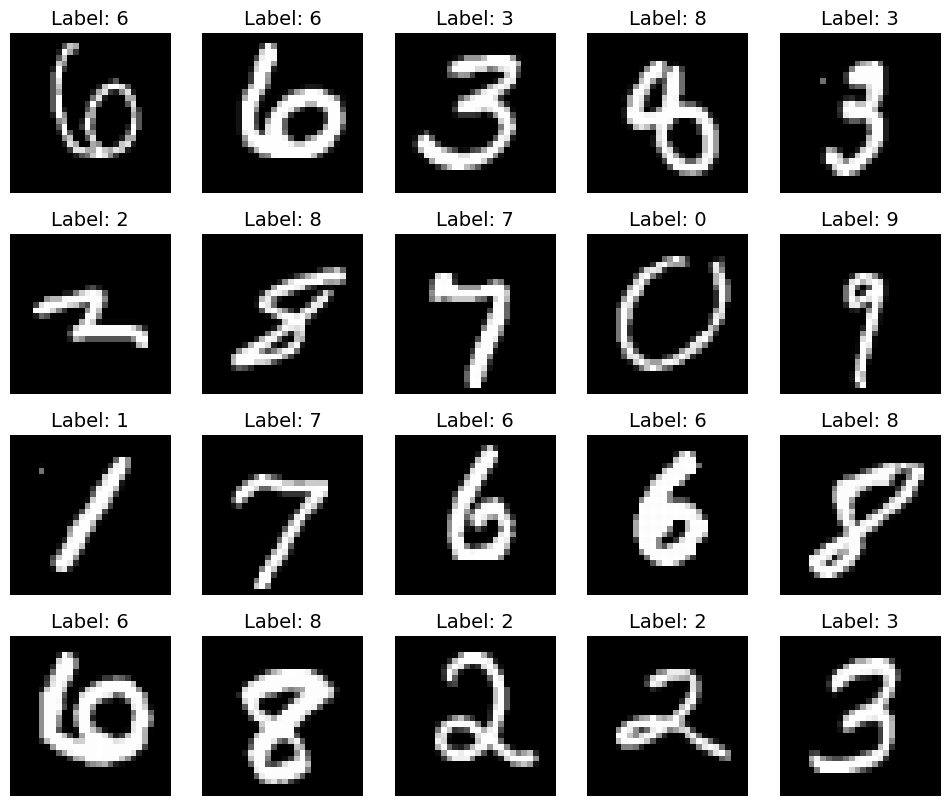

In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Print information and statistics of the first batch of images
print("Images shapes: ", images.shape)
print("Labels shape: ", labels.shape)
print(f'Mean={images.mean()}, Std={images.std()}')

fig = plt.figure(figsize=(12,10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap = 'gray', interpolation = 'none')
    plt.title(f'Label: {labels[i]}', fontsize=14)
    plt.axis('off')


### Implementing a two-convolutional layer and 1 fully connected layer neural network

In [6]:
class CNN(torch.nn.Module): # inherit the torch.nn.Module, the base class for all Pytorch Neural nets
    def __init__(self):
        super(CNN, self).__init__()

        # 1st convolution 
        self.conv1 = torch.nn.Sequential( #define conv1, a sequential container
            torch.nn.Conv2d(
                in_channels=1, # 1 input channel
                out_channels=10, # 10 output channels
                kernel_size=5, # kernel/filter of 5x5 size
                stride=1, # stride size
                padding=0 # no padding
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        # 2nd convolution
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d( # the second conv layer takes the output from conv1
                in_channels=10, # the 10 channels = the 10 outputs from conv1
                out_channels=20, # produces 20 output channels
                kernel_size=5,
                stride=1,
                padding=0,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )

        # Full-connected layer
        self.fc = torch.nn.Linear(320,10) #the fully connected layer tht takes in 320, outputs 10
        self.act = torch.nn.ReLU()

    # Forward pass
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        y_output = x

        return y_output
    
model = CNN().to(DEVICE)
print(model)


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=320, out_features=10, bias=True)
  (act): ReLU()
)


### Implement optimizer to train neural net model

In [7]:
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []

    for i, (img, label) in enumerate(train_loader):

        #___________________
        optimizer.zero_grad()
        output = model(img)
        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(output, label)

        loss.backward()
        optimizer.step()
        #____________________

        # Record training loss every log_interval and keep counter of total training images seen

        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append(
                (i * batch_size) + img.size(0) + epoch + len(train_loader.dataset)
            )
    
    return losses, counter

In [8]:
def test_one_epoch(test_loader, model, device):
    model.eval()  # Set to evaluation mode
    test_losses = []
    correct = 0
    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():  # Disable gradient computation
        for img, label in test_loader:
            img, label = img.to(device), label.to(device)  # Move data to the specified device
            output = model(img)  # Forward pass
            loss = criterion(output, label)  # Calculate loss
            
            test_losses.append(loss.item())  # Append loss for each batch
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(label.view_as(pred)).sum().item()  # Count correct predictions

    average_loss = sum(test_losses) / len(test_losses)  # Average test loss
    return average_loss, correct  # Return average loss and correct predictions


### Test Accuracy

In [9]:
def get_test_accuracy(model):
    # Hyperparamaters
    lr = 0.001
    max_epochs = 10
    gamma = 0.95

    # Recording data
    log_interval = 100

    # Instantiate optimizer (model was created in previous cell)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Use for CNN model
    # Optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    train_losses = []
    train_counter = []

    test_losses = []
    test_correct = []

    for epoch in trange(max_epochs, leave=True, desc='Epochs'):
        train_loss, counter = train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
        test_loss, num_correct = test_one_epoch(test_loader, model, DEVICE)

        # Record results
        train_losses.extend(train_loss)
        train_counter.extend(counter)
        test_losses.append(test_loss)
        test_correct.append(num_correct)

        print(train_loss, test_loss, num_correct)

        print(f"Test accuracy: {test_correct[-1]/len(test_loader.dataset)}")

        test_accuracy = test_correct[-1]/len(test_loader.dataset)

    return train_losses, test_losses, test_accuracy

train_losses_conv, test_losses_conv, test_accuracy_conv = get_test_accuracy(model)

Epochs:  10%|█         | 1/10 [00:13<02:03, 13.76s/it]

[2.304746627807617, 2.2897422313690186, 2.2831454277038574, 2.29350209236145, 2.270697593688965, 2.2946250438690186, 2.2770566940307617, 2.26967453956604, 2.274388551712036] 2.268701431847839 16104
Test accuracy: 0.2684


Epochs:  20%|██        | 2/10 [00:27<01:47, 13.47s/it]

[2.270589828491211, 2.2676329612731934, 2.255035161972046, 2.254673957824707, 2.232236862182617, 2.228665351867676, 2.22542405128479, 2.199784994125366, 2.210533857345581] 2.1923655413869603 30892
Test accuracy: 0.5148666666666667


Epochs:  30%|███       | 3/10 [00:39<01:32, 13.21s/it]

[2.1862404346466064, 2.164041519165039, 2.1451566219329834, 2.1133551597595215, 2.071255683898926, 2.0379843711853027, 1.9677175283432007, 1.9747117757797241, 1.8355265855789185] 1.8352189712178733 40461
Test accuracy: 0.67435


Epochs:  40%|████      | 4/10 [00:52<01:18, 13.00s/it]

[1.6689437627792358, 1.608406901359558, 1.6016288995742798, 1.3927297592163086, 1.2652053833007812, 1.2155780792236328, 1.030164122581482, 1.0927619934082031, 0.8337174654006958] 0.8829735664924833 47696
Test accuracy: 0.7949333333333334


Epochs:  50%|█████     | 5/10 [01:06<01:06, 13.20s/it]

[0.807174801826477, 0.6920008063316345, 0.7005158066749573, 0.6361805200576782, 0.4341593086719513, 0.7889552712440491, 0.6078053712844849, 0.6424049139022827, 0.5868700742721558] 0.5643868151504093 50605
Test accuracy: 0.8434166666666667


Epochs:  60%|██████    | 6/10 [01:20<00:54, 13.54s/it]

[0.4447318911552429, 0.4580261707305908, 0.49248430132865906, 0.4080427885055542, 0.43996530771255493, 0.4397856891155243, 0.5463697910308838, 0.39464500546455383, 0.406503826379776] 0.46073252000788384 52134
Test accuracy: 0.8689


Epochs:  70%|███████   | 7/10 [01:34<00:40, 13.65s/it]

[0.42322877049446106, 0.5053228735923767, 0.6270370483398438, 0.27124905586242676, 0.3998836874961853, 0.40324339270591736, 0.3744865953922272, 0.7128400206565857, 0.4861384332180023] 0.4062390150244175 52957
Test accuracy: 0.8826166666666667


Epochs:  80%|████████  | 8/10 [01:49<00:28, 14.29s/it]

[0.4309992492198944, 0.2578485310077667, 0.39015915989875793, 0.22066740691661835, 0.3051403760910034, 0.22070972621440887, 0.6592031717300415, 0.4572467803955078, 0.4154730439186096] 0.3702392016551388 53457
Test accuracy: 0.89095


Epochs:  90%|█████████ | 9/10 [02:02<00:13, 13.64s/it]

[0.6253057718276978, 0.3636445105075836, 0.28637051582336426, 0.34239622950553894, 0.31422409415245056, 0.21357330679893494, 0.2910725176334381, 0.47620198130607605, 0.3207069933414459] 0.3438376111508623 53931
Test accuracy: 0.89885


Epochs: 100%|██████████| 10/10 [02:14<00:00, 13.41s/it]

[0.32710903882980347, 0.37659281492233276, 0.4734603464603424, 0.4705655872821808, 0.17729723453521729, 0.2504844665527344, 0.18887735903263092, 0.30020061135292053, 0.35968220233917236] 0.3211007339836184 54311
Test accuracy: 0.9051833333333333


### Plott the Training and test loss curves

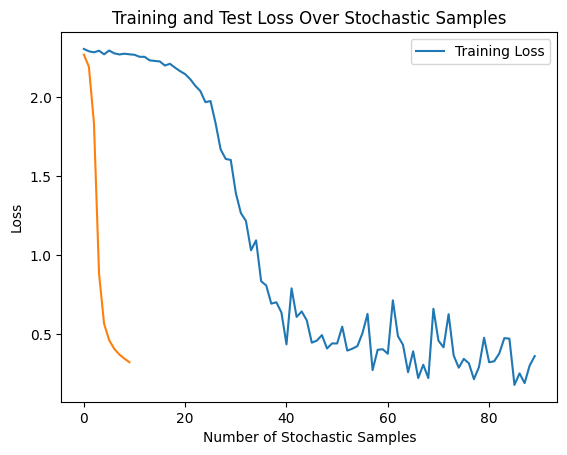

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_losses collects training losses from each log interval
# and test_losses collects the average test loss per epoch

plt.figure()
plt.plot(train_losses_conv, label='Training Loss')  # Training loss as collected
# plt.plot(np.linspace(0, len(train_losses_conv), len(test_losses_conv)), test_losses_conv, label='Test Loss', marker='o')  # Adjust x-axis for test loss
plt.plot(test_losses_conv)
plt.xlabel('Number of Stochastic Samples')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss Over Stochastic Samples')
plt.show()


In [11]:
# Implementing fully connected neural network 

import torch
import torch.nn as nn

In [12]:
# Fully connected NN
class FC_NN(torch.nn.Module):
    # mnist is 28x28 pixels = 784 input size
    # vary hidden size to test different widths
    def __init__(self, input_size=784, width=128, output_size=10):
        super(FC_NN, self).__init__()
        
        # Define NN layers
        self.fc_in = torch.nn.Linear(input_size, width) # Fully connected input
        self.act = torch.nn.ReLU()  # activation layer
        
        self.fc_out = torch.nn.Linear(width, output_size)  # Fully connected output

    def forward(self, x):
        x = torch.flatten(x, 1) # Flatten input -> input_size,    
        x = self.fc_in(x) # where self.fc is nn.Linear(28*28, 10 
        x = self.act(x)  # activation layer
        y_output = self.fc_out(x)  # Output layer
        return y_output

# Set the device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")





In [13]:
# Initialize the model
test_accuracy_widths = []
widths = [32, 64, 128, 256]
for each_width in widths:
    FC_model = FC_NN(width=each_width).to(device)
    train_loss, test_loss, test_accuracy = get_test_accuracy(model=FC_model)

    # Build list of final accuracies for each width
    test_accuracy_widths.append(test_accuracy)



Epochs:  10%|█         | 1/10 [00:06<01:00,  6.76s/it]

[2.3130176067352295, 2.2939043045043945, 2.271732807159424, 2.2619526386260986, 2.2373874187469482, 2.1842644214630127, 2.1713969707489014, 2.159769058227539, 2.1502389907836914] 2.1191931810460365 32131
Test accuracy: 0.5355166666666666


Epochs:  20%|██        | 2/10 [00:14<00:57,  7.15s/it]

[2.0860562324523926, 2.0469796657562256, 2.0287601947784424, 2.012233257293701, 1.9808216094970703, 1.969726800918579, 1.9077404737472534, 1.8844512701034546, 1.911956548690796] 1.867029438267893 41038
Test accuracy: 0.6839666666666666


Epochs:  30%|███       | 3/10 [00:21<00:50,  7.18s/it]

[1.9188764095306396, 1.8580173254013062, 1.8229889869689941, 1.7693272829055786, 1.719199538230896, 1.642724633216858, 1.6568918228149414, 1.587510347366333, 1.6352099180221558] 1.5866016971785377 43832
Test accuracy: 0.7305333333333334


Epochs:  40%|████      | 4/10 [00:28<00:43,  7.32s/it]

[1.4733545780181885, 1.4707616567611694, 1.3755509853363037, 1.4387671947479248, 1.4357889890670776, 1.4865950345993042, 1.4301133155822754, 1.318855881690979, 1.301196813583374] 1.3217862323403105 45917
Test accuracy: 0.7652833333333333


Epochs:  50%|█████     | 5/10 [00:36<00:36,  7.32s/it]

[1.1951520442962646, 1.3076707124710083, 1.1962274312973022, 1.2092928886413574, 1.1218812465667725, 1.2661731243133545, 1.1685010194778442, 1.0557641983032227, 1.1648961305618286] 1.1066390916482727 47443
Test accuracy: 0.7907166666666666


Epochs:  60%|██████    | 6/10 [00:43<00:29,  7.38s/it]

[1.0494405031204224, 1.039452314376831, 1.010667085647583, 0.9575573801994324, 1.158189296722412, 0.9731014966964722, 0.9457242488861084, 0.9512664079666138, 0.9380795359611511] 0.9468831350045926 48650
Test accuracy: 0.8108333333333333


Epochs:  70%|███████   | 7/10 [00:51<00:22,  7.35s/it]

[0.8597842454910278, 1.039230227470398, 1.0758395195007324, 0.9235548377037048, 0.875299334526062, 0.8854658007621765, 0.8894115090370178, 0.7873697280883789, 0.7777336239814758] 0.8312598208565194 49410
Test accuracy: 0.8235


Epochs:  80%|████████  | 8/10 [00:58<00:14,  7.27s/it]

[0.9778146743774414, 0.7565720677375793, 0.7898790240287781, 0.9269627332687378, 0.9177858233451843, 0.752578854560852, 0.6964553594589233, 0.6899709105491638, 0.7090530395507812] 0.7464329402075648 50024
Test accuracy: 0.8337333333333333


Epochs:  90%|█████████ | 9/10 [01:05<00:07,  7.30s/it]

[0.7057597637176514, 0.7849761843681335, 0.6417922377586365, 0.675578236579895, 0.607978105545044, 0.6160561442375183, 0.6452024579048157, 0.8128925561904907, 0.755104124546051] 0.6824737916241831 50573
Test accuracy: 0.8428833333333333


Epochs: 100%|██████████| 10/10 [01:12<00:00,  7.27s/it]


[0.6203163266181946, 0.6963881254196167, 0.7218765020370483, 0.6713443398475647, 0.677144467830658, 0.6325061321258545, 0.5501470565795898, 0.7242575287818909, 0.700343132019043] 0.6330695841103983 51030
Test accuracy: 0.8505


Epochs:  10%|█         | 1/10 [00:06<01:01,  6.79s/it]

[2.27813458442688, 2.2665820121765137, 2.2619051933288574, 2.241976022720337, 2.1955010890960693, 2.1923635005950928, 2.171325922012329, 2.1887269020080566, 2.1026971340179443] 2.122775257777558 32537
Test accuracy: 0.5422833333333333


Epochs:  20%|██        | 2/10 [00:13<00:54,  6.86s/it]

[2.0653858184814453, 2.0829684734344482, 2.0596704483032227, 2.0168750286102295, 1.9354774951934814, 2.0072391033172607, 1.953916072845459, 1.8873430490493774, 1.9433586597442627] 1.8685083841718335 37239
Test accuracy: 0.62065


Epochs:  30%|███       | 3/10 [00:21<00:50,  7.20s/it]

[1.853063702583313, 1.8187031745910645, 1.7747782468795776, 1.7468830347061157, 1.6981043815612793, 1.67499840259552, 1.5932657718658447, 1.6428236961364746, 1.502852201461792] 1.5752181310389342 41471
Test accuracy: 0.6911833333333334


Epochs:  40%|████      | 4/10 [00:28<00:44,  7.36s/it]

[1.5189640522003174, 1.4708309173583984, 1.4497121572494507, 1.4684327840805054, 1.5246752500534058, 1.3456476926803589, 1.351646065711975, 1.4444762468338013, 1.3022503852844238] 1.2989583927303998 45178
Test accuracy: 0.7529666666666667


Epochs:  50%|█████     | 5/10 [00:36<00:36,  7.31s/it]

[1.2349274158477783, 1.134872317314148, 1.1858793497085571, 1.2815989255905151, 1.2719613313674927, 1.2732750177383423, 1.1688045263290405, 1.0611135959625244, 1.1253173351287842] 1.0795685948212264 47970
Test accuracy: 0.7995


Epochs:  60%|██████    | 6/10 [00:42<00:28,  7.10s/it]

[0.9647069573402405, 1.1045422554016113, 0.9700314998626709, 1.021888017654419, 0.9291437864303589, 1.038259506225586, 0.8724727034568787, 0.8626888394355774, 0.9738984107971191] 0.9210400007553955 49119
Test accuracy: 0.81865


Epochs:  70%|███████   | 7/10 [00:49<00:20,  6.95s/it]

[0.8571423292160034, 0.9222140908241272, 0.8969203233718872, 0.9496923089027405, 0.8838874697685242, 0.7970052361488342, 0.9152743220329285, 0.7921381592750549, 0.856894314289093] 0.8084368265069115 49912
Test accuracy: 0.8318666666666666


Epochs:  80%|████████  | 8/10 [00:56<00:13,  6.86s/it]

[0.9031839966773987, 0.7963670492172241, 0.8707989454269409, 0.7202047109603882, 0.7162851691246033, 0.7550711035728455, 0.6652937531471252, 0.6472041010856628, 0.6417682766914368] 0.7269688260390051 50429
Test accuracy: 0.8404833333333334


Epochs:  90%|█████████ | 9/10 [01:02<00:06,  6.82s/it]

[0.5791500806808472, 0.6535176634788513, 0.6544172167778015, 0.5910274982452393, 0.6129516363143921, 0.6795907616615295, 0.6478362083435059, 0.48974472284317017, 0.6187900304794312] 0.6660694234660948 50947
Test accuracy: 0.8491166666666666


Epochs: 100%|██████████| 10/10 [01:09<00:00,  6.98s/it]


[0.5764414668083191, 0.6049396395683289, 0.6985291242599487, 0.7043304443359375, 0.522565484046936, 0.656917929649353, 0.7915918827056885, 0.7001295685768127, 0.4771490693092346] 0.6190048626014418 51295
Test accuracy: 0.8549166666666667


Epochs:  10%|█         | 1/10 [00:07<01:06,  7.44s/it]

[2.296319007873535, 2.266634225845337, 2.2622973918914795, 2.233755350112915, 2.2113208770751953, 2.204155683517456, 2.1865696907043457, 2.171056032180786, 2.1368906497955322] 2.134891916948087 28472
Test accuracy: 0.4745333333333333


Epochs:  20%|██        | 2/10 [00:14<00:55,  7.00s/it]

[2.1079599857330322, 2.1135246753692627, 2.0246987342834473, 2.0499181747436523, 2.0212345123291016, 2.0496041774749756, 1.9766308069229126, 1.9605774879455566, 1.8678913116455078] 1.8869532786452694 38603
Test accuracy: 0.6433833333333333


Epochs:  30%|███       | 3/10 [00:20<00:47,  6.84s/it]

[1.8762060403823853, 1.7955102920532227, 1.7544888257980347, 1.7274794578552246, 1.6216545104980469, 1.6377395391464233, 1.6355173587799072, 1.6243020296096802, 1.6856220960617065] 1.581501033133281 44810
Test accuracy: 0.7468333333333333


Epochs:  40%|████      | 4/10 [00:27<00:40,  6.77s/it]

[1.5301566123962402, 1.5333046913146973, 1.472707986831665, 1.4218566417694092, 1.4042887687683105, 1.3360251188278198, 1.368101954460144, 1.316100835800171, 1.3206628561019897] 1.2868055163034753 47101
Test accuracy: 0.7850166666666667


Epochs:  50%|█████     | 5/10 [00:34<00:33,  6.73s/it]

[1.233402132987976, 1.205756664276123, 1.073423981666565, 0.9997401237487793, 1.246183156967163, 1.143606424331665, 1.0905036926269531, 0.966688334941864, 1.1074624061584473] 1.058561058186773 48390
Test accuracy: 0.8065


Epochs:  60%|██████    | 6/10 [00:41<00:27,  6.87s/it]

[1.1270097494125366, 1.0669562816619873, 1.007630705833435, 0.9536928534507751, 0.9920686483383179, 0.9655453562736511, 0.9031589031219482, 0.8559113144874573, 0.8601228594779968] 0.9001636692582925 49464
Test accuracy: 0.8244


Epochs:  70%|███████   | 7/10 [00:48<00:21,  7.06s/it]

[0.8545952439308167, 0.7318030595779419, 0.8370574712753296, 0.7783098816871643, 0.8773952126502991, 0.875737190246582, 0.8014351725578308, 0.812238335609436, 0.7141254544258118] 0.7910397716803845 50161
Test accuracy: 0.8360166666666666


Epochs:  80%|████████  | 8/10 [00:55<00:14,  7.01s/it]

[0.7786179780960083, 0.7654129862785339, 0.8196971416473389, 0.7308101654052734, 0.6965357065200806, 0.7002021074295044, 0.6508052349090576, 0.7658167481422424, 0.7296072840690613] 0.7132416861906234 50608
Test accuracy: 0.8434666666666667


Epochs:  90%|█████████ | 9/10 [01:02<00:07,  7.12s/it]

[0.7611657381057739, 0.5662444233894348, 0.7199599742889404, 0.7104670405387878, 0.755921483039856, 0.745639443397522, 0.6774198412895203, 0.7029717564582825, 0.6855262517929077] 0.6555046109693137 51055
Test accuracy: 0.8509166666666667


Epochs: 100%|██████████| 10/10 [01:09<00:00,  6.98s/it]


[0.5296210646629333, 0.6893674731254578, 0.7105005979537964, 0.6606069207191467, 0.6706774234771729, 0.5259518027305603, 0.6200850009918213, 0.5892118215560913, 0.5453862547874451] 0.6110098519876822 51396
Test accuracy: 0.8566


Epochs:  10%|█         | 1/10 [00:06<01:01,  6.81s/it]

[2.327247381210327, 2.2685556411743164, 2.2696011066436768, 2.2464232444763184, 2.228201389312744, 2.2298903465270996, 2.2062644958496094, 2.166722297668457, 2.162787675857544] 2.148421096649251 36394
Test accuracy: 0.6065666666666667


Epochs:  20%|██        | 2/10 [00:13<00:54,  6.76s/it]

[2.1515374183654785, 2.1262025833129883, 2.096590757369995, 2.0413403511047363, 2.0116562843322754, 1.9614152908325195, 1.9223092794418335, 1.9841158390045166, 1.9766985177993774] 1.902226099327429 44586
Test accuracy: 0.7431


Epochs:  30%|███       | 3/10 [00:20<00:47,  6.83s/it]

[1.9269813299179077, 1.866889476776123, 1.8262680768966675, 1.75709867477417, 1.7368301153182983, 1.7215770483016968, 1.6176856756210327, 1.6838916540145874, 1.5611413717269897] 1.5847001276544925 45318
Test accuracy: 0.7553


Epochs:  40%|████      | 4/10 [00:27<00:42,  7.00s/it]

[1.6301467418670654, 1.5145100355148315, 1.4248101711273193, 1.5087471008300781, 1.4973571300506592, 1.438250184059143, 1.3960905075073242, 1.3255878686904907, 1.3363990783691406] 1.2807739099968216 47096
Test accuracy: 0.7849333333333334


Epochs:  50%|█████     | 5/10 [00:35<00:36,  7.24s/it]

[1.188825011253357, 1.203155755996704, 1.225356101989746, 1.1540156602859497, 1.1198711395263672, 1.1767382621765137, 1.0216410160064697, 1.0299556255340576, 1.1991463899612427] 1.0510684770307561 48484
Test accuracy: 0.8080666666666667


Epochs:  60%|██████    | 6/10 [00:42<00:29,  7.31s/it]

[1.0097354650497437, 0.8846359848976135, 1.0780200958251953, 1.0683289766311646, 0.9713892936706543, 1.143457055091858, 0.942196249961853, 0.9270932078361511, 0.992106020450592] 0.8926332727678294 49512
Test accuracy: 0.8252


Epochs:  70%|███████   | 7/10 [00:50<00:21,  7.31s/it]

[0.8058121800422668, 1.0042524337768555, 0.7720398306846619, 0.7809469103813171, 0.9924209117889404, 0.9051304459571838, 0.7652851343154907, 0.7311359643936157, 0.8523364663124084] 0.7827583874847843 50292
Test accuracy: 0.8382


Epochs:  80%|████████  | 8/10 [00:56<00:14,  7.13s/it]

[0.862097978591919, 0.6964982748031616, 0.680335521697998, 0.6347568035125732, 0.7128291726112366, 0.757805585861206, 0.7328296303749084, 0.7233273386955261, 0.6468537449836731] 0.7043132729240572 50840
Test accuracy: 0.8473333333333334


Epochs:  90%|█████████ | 9/10 [01:03<00:07,  7.09s/it]

[0.5921501517295837, 0.6276082396507263, 0.7235692739486694, 0.5779857039451599, 0.8268699049949646, 0.6516754031181335, 0.657207190990448, 0.6255430579185486, 0.5701403021812439] 0.645876000367248 51260
Test accuracy: 0.8543333333333333


Epochs: 100%|██████████| 10/10 [01:11<00:00,  7.15s/it]

[0.6219079494476318, 0.6710370779037476, 0.5683719515800476, 0.6029458045959473, 0.6263440251350403, 0.5738781690597534, 0.6967466473579407, 0.617980420589447, 0.5010316371917725] 0.6008759394192746 51619
Test accuracy: 0.8603166666666666


In [14]:
# Report the accuracies of each result:
for i in range(len(widths)):
    print(f"The accuracy for the NN of width {widths[i]} is {test_accuracy_widths[i]}")
print(f"The convolutional neural network reported a final accuracy of {test_accuracy_conv}")



The accuracy for the NN of width 32 is 0.8505
The accuracy for the NN of width 64 is 0.8549166666666667
The accuracy for the NN of width 128 is 0.8566
The accuracy for the NN of width 256 is 0.8603166666666666
The convolutional neural network reported a final accuracy of 0.9051833333333333


In comparing the results, the reported accuracies are not surprising.
First, we can see that as the width of the neural network is increased, so is the accuracy of the model, albeit by a very small amount. This is likely due to the extreme simpliciy of the fully connected neural network created; the model was created with only a single activation layer. More activation layers would take advantage of the greater depth of the model and likely show an ever greater increase in accuracy.

As well, the convolutional model was 0.4 greater in accuracy than the most accurate fully connected NN. The convolutional model was provided in lecture and was more optimized for dealing with MNIST data. This model had 2 convolutional layers, allowing the network to learn at a higher level of depth. As well, pooling was implemented as well as a fully connected layer. Finally, the convolutional model included its own fully connected layer. Because both models had a full connected layer which ued ReLU, and used the same optimization strategy of SGD, it is reasonable to assume that the convolutional model was superior to the fully connected model in every way, which is why the accuracy was higher. 

For the fully connected neural networks the number of parameters is as follows:
784 in the input
Hidden layer widths varied from: [32, 64, 128, 256]
The output layer was 10 nodes

This yields (784 * width) + width(the bias) + width * 10 + 10 (the bias)

In [15]:
for each in widths:
    print(f"The number of parameters for the FC NN of width {each} is {(784 * each) + each + (each * 10) + 10}")

The number of parameters for the FC NN of width 32 is 25450
The number of parameters for the FC NN of width 64 is 50890
The number of parameters for the FC NN of width 128 is 101770
The number of parameters for the FC NN of width 256 is 203530


Convolutional parameter count is dictated by (filter width * filter height * input size + bias) * output size

For conv1: 
kernel size = 5x5
input = 1
output = 10

(5 * 5 * 1 + 1) (bias) * 10 = 260

conv2:
kernel = 5x5
input = 10
output = 20

(5 * 5 * 10 + 1) (bias) * 20 = 5020

fully connected layer:
input = 320
output = 10

(320 * 10) + bias (10) = 3210 

Total = 260 + 5020 + 3210 = 8490

In [16]:
print(f"The number of parameters for the convolutional NN is 8490")

The number of parameters for the convolutional NN is 8490


Regarding my findings, it is most notable that increasing the width of a hidden layer within a fully connected neural network will quickly have a direct impact on the number of parameters. This should not be surpising, as my first tested width was 32, and the final width I tested was 256. That is an increased width by a factor of 8. Unsurprisingly, the difference in parmaters between the FC NN at a width of 32 and 256 was about a factor of 8. Yet, the convolutional neural network, which had the lowest number of parameters had the highest accuracy.

This demonstrates that the number of parameters in a neural network is not directly analogous to how sophisticated or accurately a model will perform. 